In [1]:
import pmx
from pmx.utils import create_folder
from pmx import gmx, ligand_alchemy, jobscript
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%pylab inline
from IPython.core.display import clear_output
import os,shutil
import re
import subprocess
import glob
import random
import pandas as pd
from AZtutorial import *
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


----------
# Introduction
__________

In this tutorial we will use pmx and Gromacs to set up alchemical free energy calculations for a relative free energy calculation study. We will further perform the simulations and estimate the actual ddG value.

The protein and ligand topologies for this case have already been generated and described in the study:<br>
*Gapsys, Perez-Benito et al. Large scale relative protein ligand binding affinities using non-equilibrium alchemy.  2020. Chemical Science<br>
https://pubs.rsc.org/en/content/articlelanding/2020/SC/C9SC03754C* <br>
All the input/output files from this work can be found on the pmx github page:<br>
*https://github.com/deGrootLab/pmx/tree/master/protLig_benchmark*

In the tutorial, we will use a pair of ligands (18625-1 and 18626-1) binding to the JNK1 kinase and estimate the relative free energy difference $\Delta\Delta G$ between these molecules. The experimentally measured double free energy difference for this edge is -3.22 kJ/mol.<br>

For the calculations, we will construct the following thermodynamic cycle:

<div>
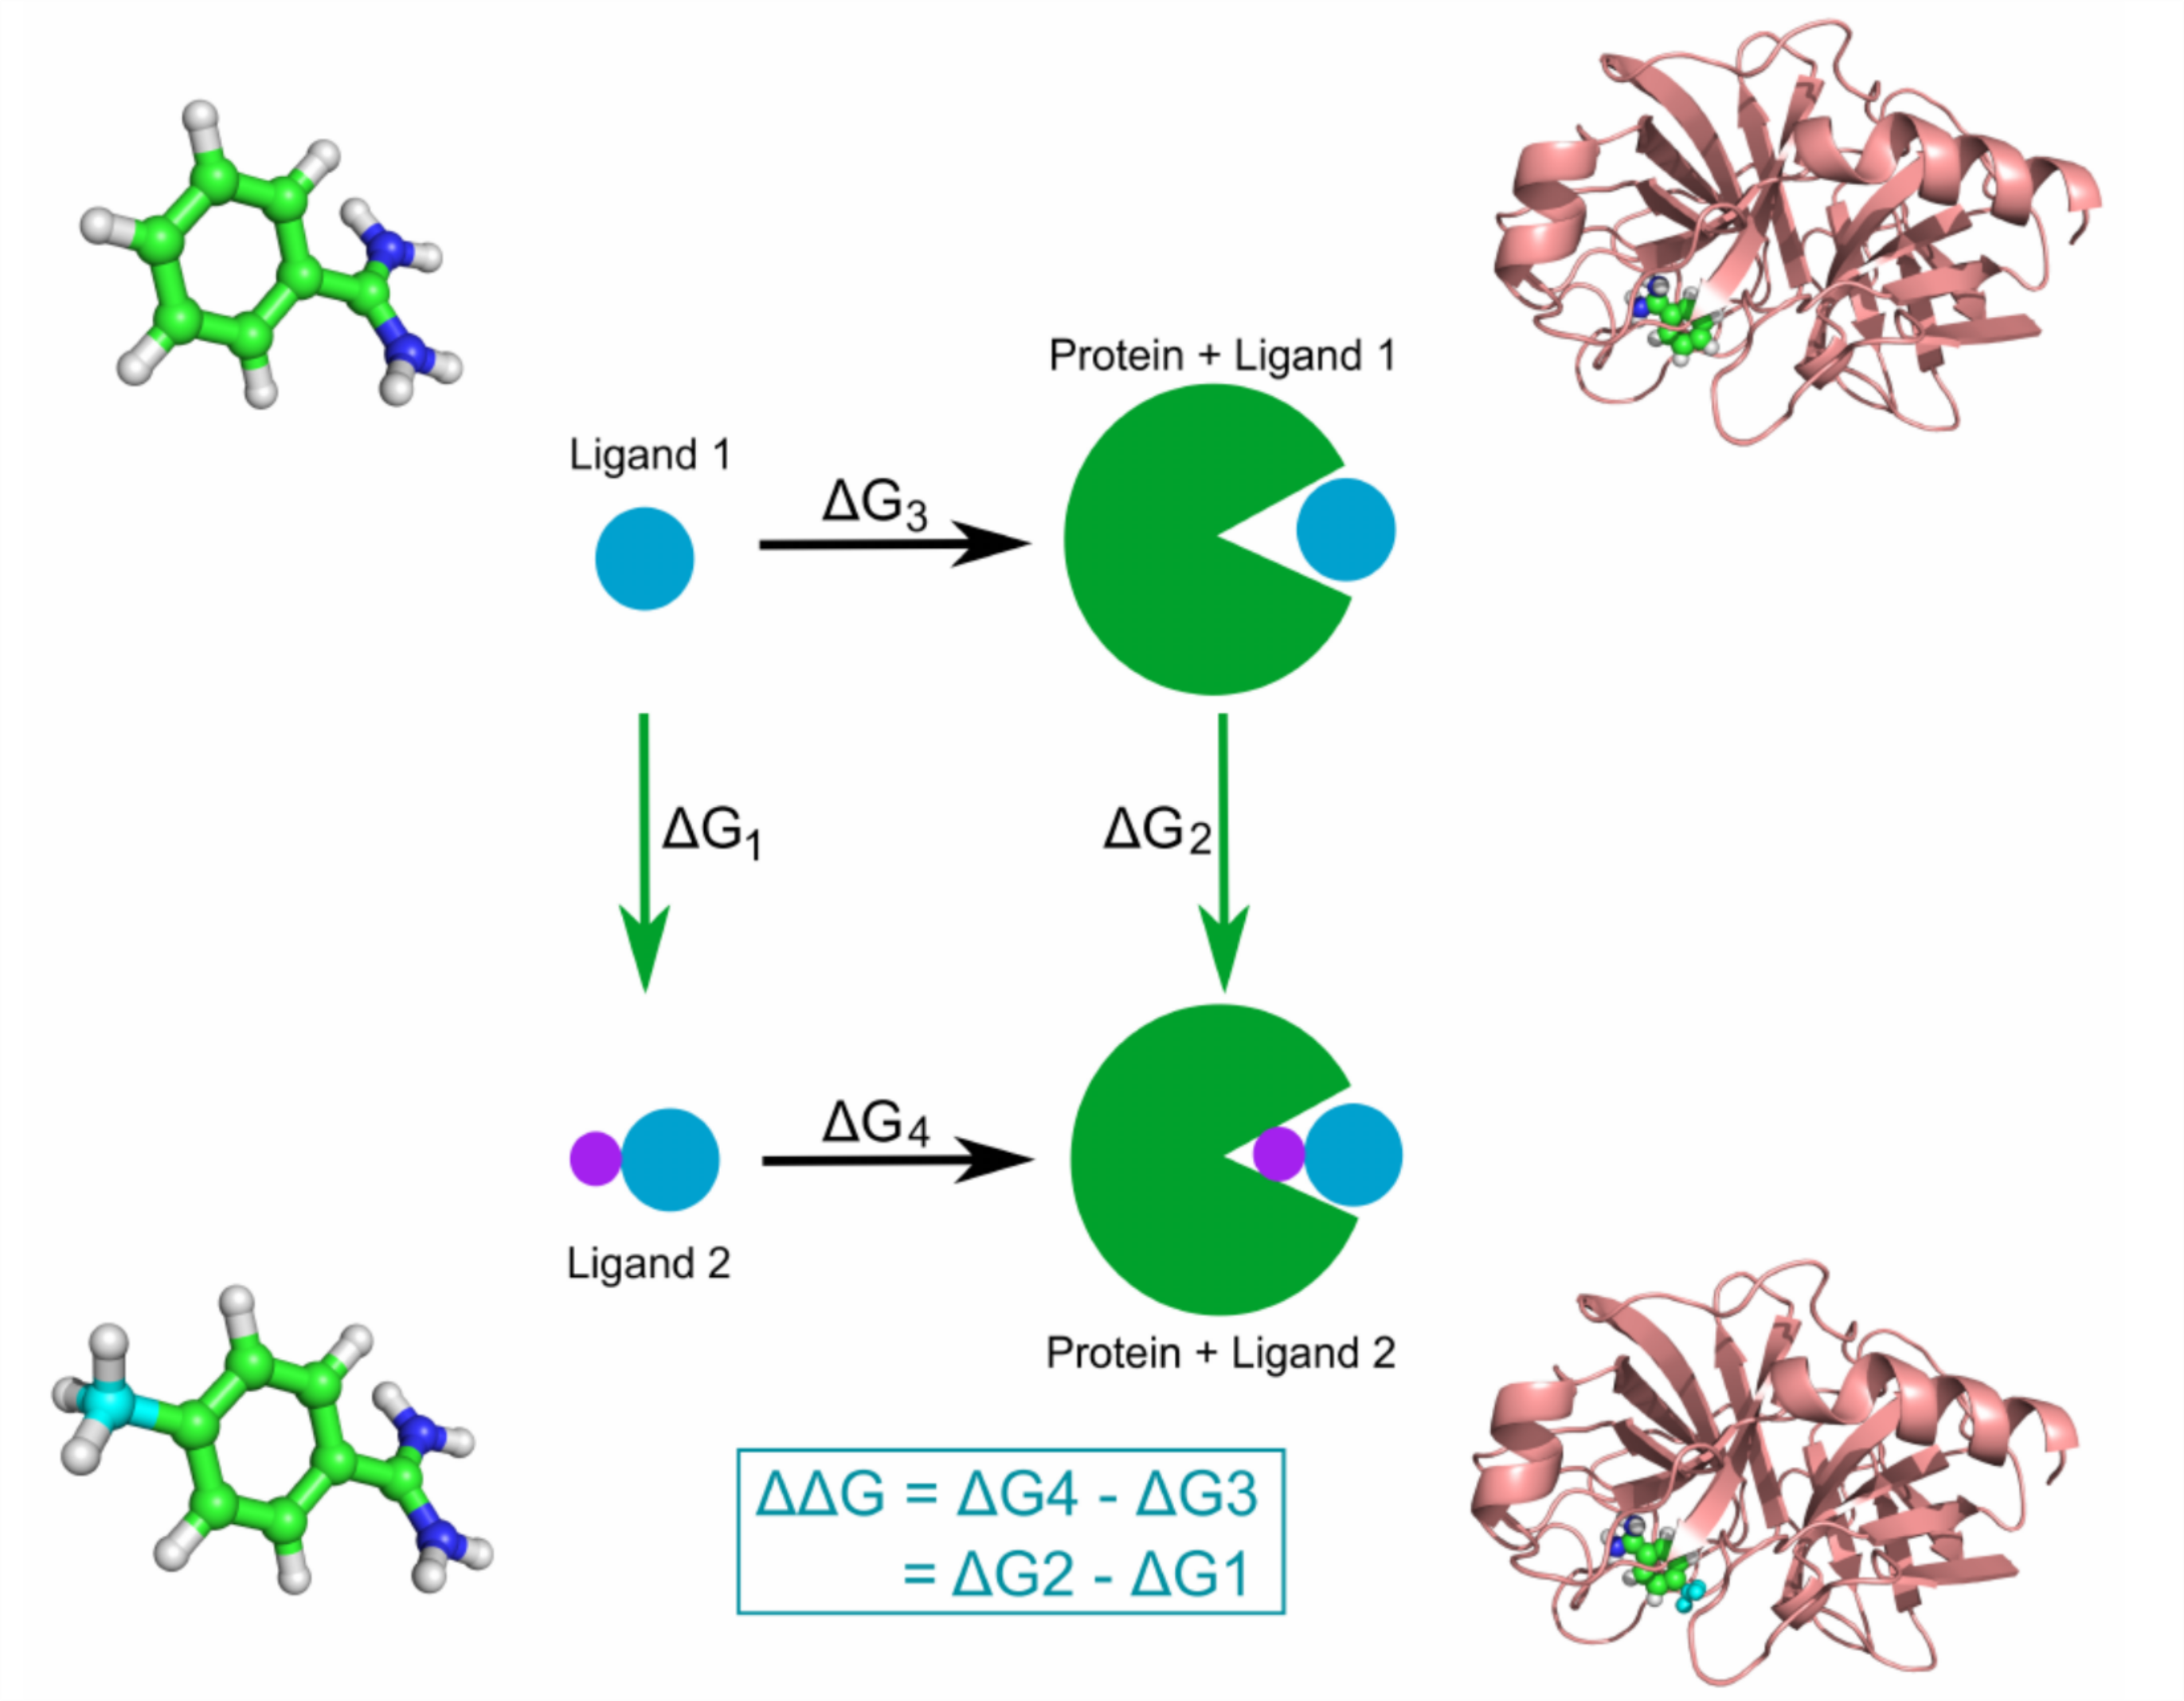
</div>


------------------
# Method
------------------
We will set up the calculations in a non-equilibrium framework.<br>
Firstly, two 6 ns long equilibrium simulations will be performed in the physical states A and B. This will be done for the ligand solvated in water and protein-ligand complex.<br>
Afterwards, we will extract snapshots from the equilibrium simulations and run rapid (50 ps) transitions in the directions A->B and A<-B.<br>
During the transitions, we will record the work required for the ligand morphing. Finally, the work will be related to $\Delta G$ by applying Crooks fluctuation theorem.

<div>
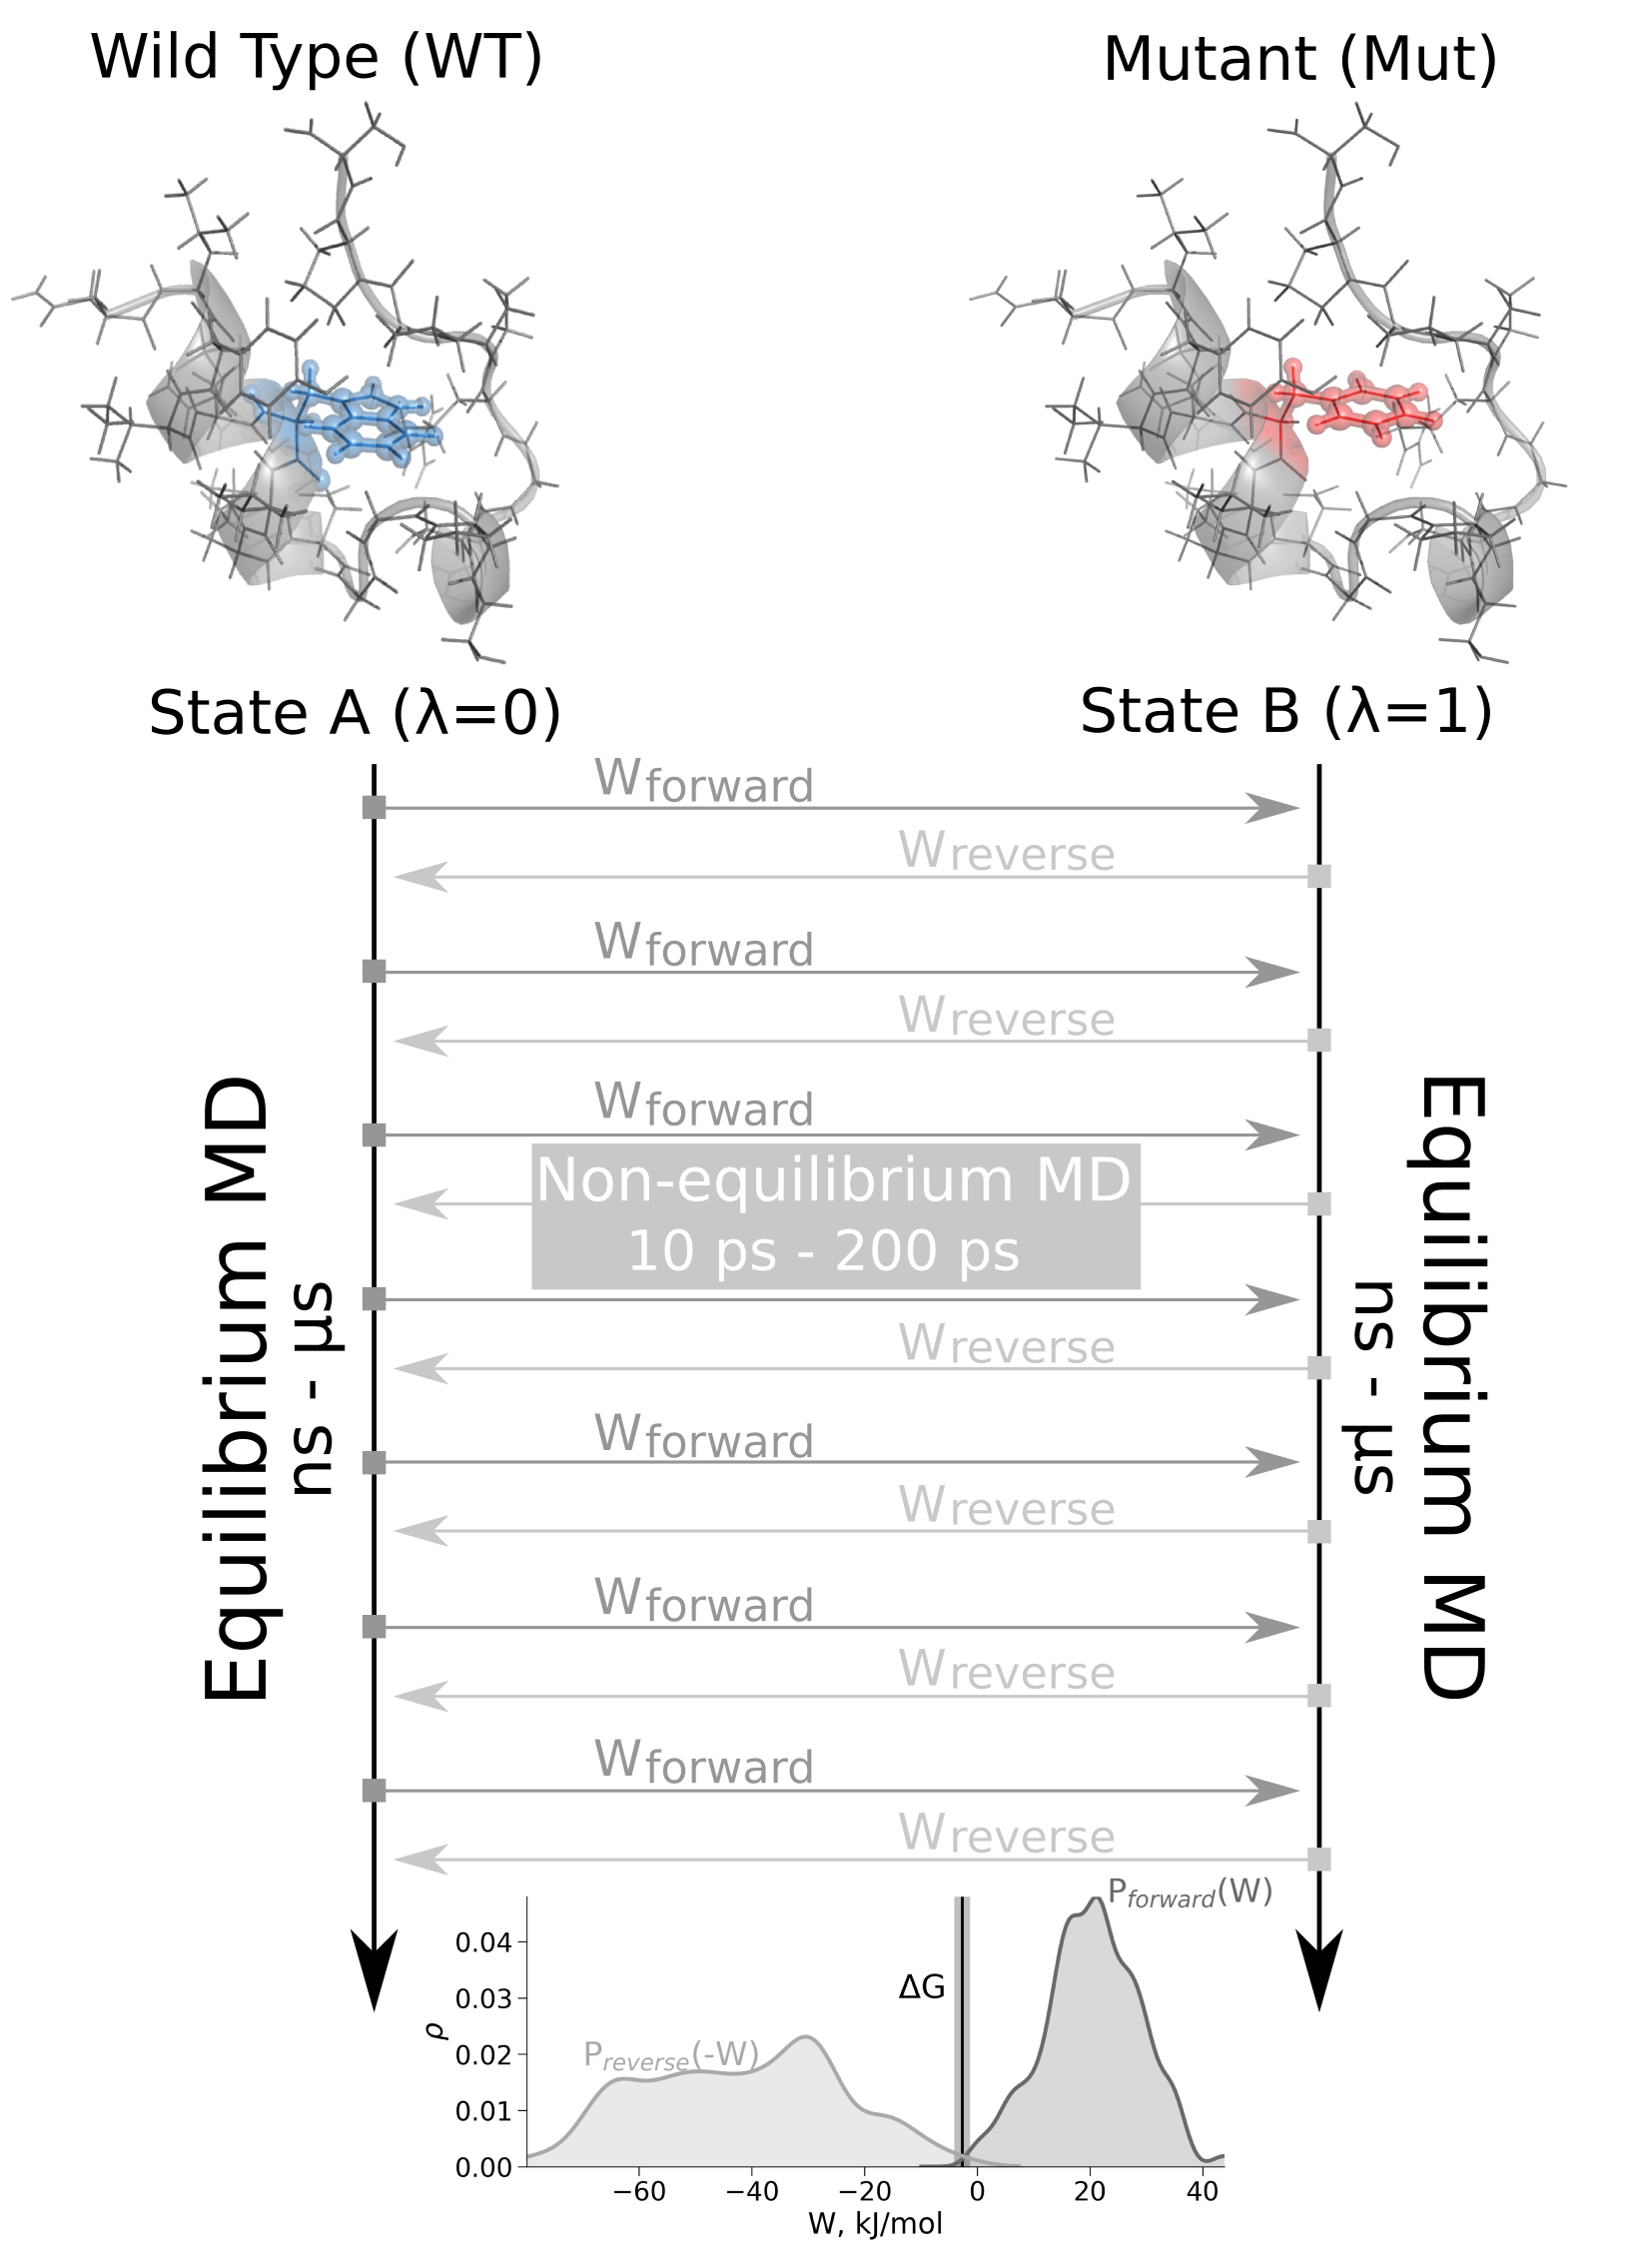
</div>

---------------
Workflow
-----------------
The overall workflow consists of the following steps:<br>
0. Initialize the working environment
1. Prepare hybrid structures/topologies
2. Prepare equilibrium simulations
3. Prepare non-equilibrium transitions
4. Analysis

`To execute the commands in the cells use Shift+Enter`

----------------
Step 0. Initialize working environment
-----------------

Here, we will define the paths to the protein and ligand topologies, as well as to the molecular dynamics parameter files (.mdp).

We will also set some main parameters: water model, salt concentration, number of simulation replicas to use.

In [2]:
# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AZtutorial( )

# set the workpath
fe.workPath = 'workpath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = 'input/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 3
# provide the path to the protein structure and topology
fe.proteinPath = 'input/protein_amber'
# provide the path to the folder with ligand structures and topologies
fe.ligandPath = 'input/ligands'
# provide edges
fe.edges = [ ['18625-1','18626-1'] ]

# finally, let's prepare the overall free energy calculation directory structure
fe.prepareFreeEnergyDir( )

edge_18625-1_18626-1

---------------------
Summary of the setup:
---------------------

   workpath: /home/vgapsys/project/make_hybrid/AZtutorial/workpath
   mdp path: /home/vgapsys/project/make_hybrid/AZtutorial/input/mdppath
   protein files: /home/vgapsys/project/make_hybrid/AZtutorial/input/protein_amber
   ligand files: /home/vgapsys/project/make_hybrid/AZtutorial/input/ligands
   number of replicase: 3
   edges:
        edge_18625-1_18626-1

---------------------
Directory structure:
---------------------

/home/vgapsys/project/make_hybrid/AZtutorial/workpath/
|
|--edge_X_Y
|--|--water
|--|--|--stateA
|--|--|--|--run1/2/3
|--|--|--|--|--em/eq_posre/eq/transitions
|--|--|--stateB
|--|--|--|--run1/2/3
|--|--|--|--|--em/eq_posre/eq/transitions
|--|--protein
|--|--|--stateA
|--|--|--|--run1/2/3
|--|--|--|--|--em/eq_posre/eq/transitions
|--|--|--stateB
|--|--|--|--run1/2/3
|--|--|--|--|--em/eq_posre/eq/transitions
|--|--hybridStrTop
|--edge_..
DONE


`1a. Firstly, let's create a hybrid structure/topology for the two ligands forming an edge.
For that we will establish a mapping of atoms to be morphed between the molecules.`

In [3]:
# this command will map the atoms of all edges found in the 'fe' object
# bVerbose flag prints the output of the command
fe.atom_mapping(bVerbose=False)

-----------------------
Performing atom mapping
-----------------------
edge_18625-1_18626-1
DONE


`1b. Secondly, we will construct a hybrid structure and topology based on the established mapping`

In [4]:
fe.hybrid_structure_topology(bVerbose=False)

----------------------------------
Creating hybrid structure/topology
----------------------------------
edge_18625-1_18626-1
DONE


`1c. Finally, we assemble the ligand and ligand+protein systems, i.e. create structures and topologies that will be used further in the step 2.`

In [5]:
fe.assemble_systems( )

----------------------
Assembling the systems
----------------------
edge_18625-1_18626-1
DONE


------------------
Step 2. Prepare equilibrium simulations.
---------------------
Prepare simulation boxes with solvent and ions.
Subsequently energy minimize the systems, prepare equilibrium simulations and start the runs.

`2a. Build boxes, solvate, add ions`

In [6]:
fe.boxWaterIons( )

----------------
Box, water, ions
----------------
edge_18625-1_18626-1
DONE


`2b. Energy minimization.`<br>
Prepare the simulation and subsequently either<br>
 a) run locally (suitable for the tutorial purpose)<br>
 b) create jobscripts to submit to the cluster

In [7]:
fe.prepare_simulation( simType='em' )

-----------------------------------------
Preparing simulation: em
-----------------------------------------
edge_18625-1_18626-1
DONE


Running energy minimization locally (e.g. on a laptop) will take 10-15 minutes for one edge.<br>
You can use the command below for that.
If you do not want to wait that long and have an access to a cluster, skip this step and proceed to the next step.

In [267]:
fe.run_simulation_locally( simType='em', bProt=False, bVerbose=True )

We can also submit the jobs to run on the cluster.<br>
This, naturally, requires some knowledge of the cluster available, queueing system and some dependencies. Several jobscript parameters allow to define the environment on the cluster. If there are additional cluster specifics, the jobscripts can be easily modified.<br>

Together with the jobscripts, a script `submit.py` will be generated. This script can be used to simply submit all the jobs to the cluster.

In [8]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2018']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgpu = True
fe.JOBgmx = 'mdrun_threads'

# create the jobscripts
fe.prepare_jobscripts(simType='em')

---------------------------------------------
Preparing jobscripts for: em
---------------------------------------------
DONE


`2c. Once the energy minimization has finished, we can prepare equilibrium simulations.`

In [9]:
fe.prepare_simulation( simType='eq' )

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_18625-1_18626-1
DONE


Again, prepare and submit the equilibrium simulation jobs to the cluster.<br>
This time the calculation will take longer (we are performing 6 ns simulations).<br>
On a node with a GPU and 8 CPUs simulations of ligand in water will take ~2 hours, ligand-protein complex will take ~10 hours.

In [423]:
fe.prepare_jobscripts(simType='eq')

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------


### The calculations for this step (and for the following step 3) would take a while. Therefore, I have already performed the simulations in advance, so we do not need to wait. ###
`To use the pre-calculated data, simply change the working directory of your tutorial object "fe" (command below). By default, all your calculations were performed in the "workpath" directory. The following command will set it to the "workpath_precalculated". We will also set the number of replicass to 1, because for the brevity of the current tutorial only one repetition of the calculation was performed.`<br>
Note, that in the folder "workpath_precalculated" only the final results, i.e. dhdl.xvg files, have been generated for all the replicas for the forwards/reverse directions for the solvated ligand and ligand-protein complex. The raw generated trajectories are only provided for two cases: 'water/stateA/run1' and 'water/stateB/run1'. This is simply due to the large size of the trajectories: all the simulation data would take more than 2 GB. This means that `Step 3` can only be performed for this one ligand transition in water. However, this is not a concern for the final analysis in `Step 4`, because the results from the transitions are present for all the cases considered in the tutorial.

In [3]:
fe.replicas = 1
fe.workPath = 'workpath_precalculated'

--------------
Step 3. Prepare non-equilibrium transitions
---------------
At this point we already have the trajectories for equilibrium ensembles of two ligand states in water and in complex with the protein.<br>

`3a.` From these simulations we will extract the snapshots and initiate rapid transitions from one state to the other.

In [11]:
fe.prepare_transitions( bGenTpr=True, bProt=False )

---------------------
Preparing transitions
---------------------
Preparing: LIG edge_18625-1_18626-1 stateA run1
Preparing: LIG edge_18625-1_18626-1 stateB run1
DONE


`3b.` Prepare submission scripts for transitions.<br>
Each transition is very short (50 ps), therefore, we can reduce the number of required CPUs and flood our cluster with many small jobs.

In [12]:
fe.JOBsimcpu = 2
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2018']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgpu = True
fe.JOBgmx = 'mdrun_threads'

fe.prepare_jobscripts(simType='transitions', bProt=False)

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


----------------
Step 4. Analysis
------------------

`4a.` Firstly, let's process the calculated work values and estimate free energy differences.<br>
The `pmx analyse` program will integrate the dhdl.xvg files to obtain the forward and reverse work values.<br>
Subsequently, the Crooks fluctuation theorem and Jarzynski estimators will be applied to relate the work distributions to $\Delta G$

In [ ]:
fe.run_analysis( bVerbose=True)

`4b.` Finally, we can collect all the results into one data structure and investigate the outcome.<br>
Let's also set the number of replicas back to 3, because results from three repeats have been pre-calculated for this tutorial.<br>
Here, we read the $\Delta G$ values and calculate $\Delta\Delta G$.<br>
The calculated error reflects the statistical uncertainty and the variation between multiple calculation repeats.

In [4]:
fe.replicas = 3
fe.analysis_summary( )

In [5]:
fe.resultsAll

,val,err_analyt,err_boot,framesA,framesB
edge_18625-1_18626-1_water_1,-8.850000,0.330000,0.290000,80.0,80.0
edge_18625-1_18626-1_protein_1,-13.460000,0.940000,0.690000,80.0,80.0
edge_18625-1_18626-1_water_2,-8.860000,0.320000,0.280000,80.0,80.0
edge_18625-1_18626-1_protein_2,-10.250000,0.550000,0.460000,80.0,80.0
edge_18625-1_18626-1_water_3,-9.150000,0.340000,0.390000,80.0,80.0
edge_18625-1_18626-1_protein_3,-12.160000,0.600000,0.590000,80.0,80.0
edge_18625-1_18626-1_water,-8.953333,0.208616,0.205286,NaN,NaN
edge_18625-1_18626-1_protein,-11.956667,0.866611,0.837343,NaN,NaN


In [6]:
fe.resultsSummary

,val,err_analyt,err_boot
edge_18625-1_18626-1,-3.003333,0.841127,0.811789
